# Analyzing snATAC-seq data of human colon samples

In [1]:
import snapatac2 as snap
from os import listdir
import numpy as np
import scanpy as sc

In [2]:
files = !ls data/*_fragments.bed.gz

In [4]:
files = files[:2]

In [5]:
datasets = {}
for fl in files:
    print(fl)
    name = fl.split("/")[-1].split("_rep1_fragments")[0]
    
    # Compute QC metric and cell by 500bp-bin matrix
    data = snap.pp.make_tile_matrix(name + "_raw.h5ad",
        fl,
        "/projects/ps-renlab/kai/genome/GRCh38/gencode.v33.basic.annotation.gtf",
        snap.genome.hg38)
    
    # Select cells based on number of unique fragments and TSS enrichment scores
    selected_cells = np.logical_and(data.obs["n_fragment"] >= 1000, data.obs["tsse"] >= 7)
    data = data[selected_cells, :]
    
    # Save filtered data to a different file
    data.copy(filename = name + "_filtered.h5ad")
    datasets[name] = data


data/colon_transverse_SM-A9HOW_rep1_fragments.bed.gz
data/colon_transverse_SM-A9VP4_rep1_fragments.bed.gz


In [6]:
datasets

{'data/colon_transverse_SM-A9HOW': View of AnnData object with n_obs × n_vars = 7512 × 6176550 backed at 'data/colon_transverse_SM-A9HOW_raw.h5ad'
     obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito',
 'data/colon_transverse_SM-A9VP4': View of AnnData object with n_obs × n_vars = 2438 × 6176550 backed at 'data/colon_transverse_SM-A9VP4_raw.h5ad'
     obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'}

In [7]:
# Merge all data. The resultant object stores references to individual data.
# Data will not be copied but remain on the disk
data = snap.AnnCollection(
    datasets,
    index_unique = "_",
    join_obsm="inner",
    label="batch"
)
data

AnnCollection object with n_obs × n_vars = 9950 × 6176550
  constructed from 2 AnnData objects
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'batch'

In [8]:
# Feature selection
features = snap.pp.select_features(data, whitelist="data/cCRE_hg38.bed.gz")

In [9]:
# Perform dimension reduction. The result is stored in `data.obsm["X_spectral"]
snap.tl.spectral(data, features=features, sample_size=10000, chunk_size=5000)

Compute similarity matrix
Normalization
Perform decomposition


In [12]:
data = data.to_adata()

In [13]:
# Perform UMAP
snap.tl.umap(data)

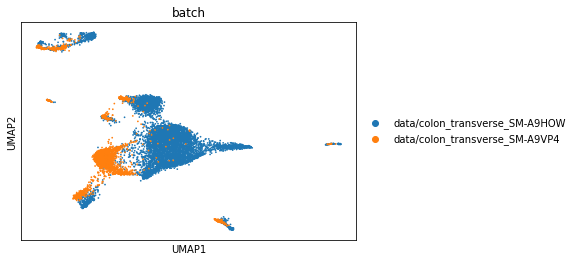

In [14]:
import scanpy as sc
sc.pl.umap(data, color="batch")

In [15]:
snap.pp.mnc_correct(data, n_neighbors=4)

In [16]:
snap.tl.umap(data, use_rep="X_spectral_corrected")

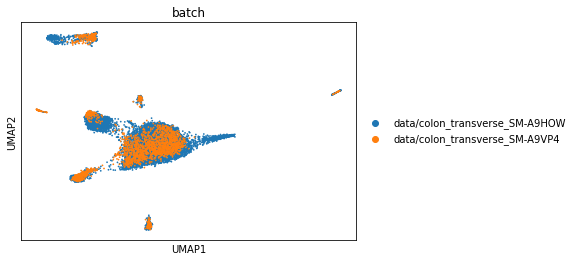

In [17]:
sc.pl.umap(data, color="batch")

In [2]:
data.write("result.h5ad")